In [ ]:
#@title Синхронизация видео с 4-х камер по аудиоканалу

In [ ]:
!pip install --upgrade -q moviepy

In [ ]:
from moviepy.editor import VideoFileClip

In [ ]:
# Подключение Google Диска
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title Сохранение аудио
#Загрузка 120 сек видео
video_1 = '/content/drive/My Drive/video/HEIAN_NIDAN_camera_1_120s_ffmpeg.mp4'
video_2 = '/content/drive/My Drive/video/HEIAN_NIDAN_camera_2_120s_ffmpeg.mp4'
video_3 = '/content/drive/My Drive/video/HEIAN_NIDAN_camera_3_120s_ffmpeg.mp4'
video_4 = '/content/drive/My Drive/video/HEIAN_NIDAN_camera_4_120s_ffmpeg.mp4'

video_files = [video_1, video_2, video_3, video_4]

for video_file in video_files:
    video = VideoFileClip(video_file)

    audio = video.audio

    # Сохранение аудио в файл
    audio_file_name = video_file.replace('.mp4', '.wav')  # Замените расширение на .wav
    audio.write_audiofile(audio_file_name)

    # Закрытие видео и аудио объектов
    audio.close()
    video.close()

MoviePy - Writing audio in /content/drive/My Drive/video/HEIAN_NIDAN_camera_1_120s_ffmpeg.wav


MoviePy - Done.
MoviePy - Writing audio in /content/drive/My Drive/video/HEIAN_NIDAN_camera_2_120s_ffmpeg.wav


MoviePy - Done.
MoviePy - Writing audio in /content/drive/My Drive/video/HEIAN_NIDAN_camera_3_120s_ffmpeg.wav


MoviePy - Done.
MoviePy - Writing audio in /content/drive/My Drive/video/HEIAN_NIDAN_camera_4_120s_ffmpeg.wav


MoviePy - Done.


In [ ]:
!pip install -q librosa

In [ ]:
import numpy as np
import librosa
import matplotlib.pyplot as plt

In [ ]:
# Загрузка аудио
audio_1 = '/content/drive/My Drive/video/HEIAN_NIDAN_camera_1_120s_ffmpeg.wav'
audio_2 = '/content/drive/My Drive/video/HEIAN_NIDAN_camera_2_120s_ffmpeg.wav'
audio_3 = '/content/drive/My Drive/video/HEIAN_NIDAN_camera_3_120s_ffmpeg.wav'
audio_4 = '/content/drive/My Drive/video/HEIAN_NIDAN_camera_4_120s_ffmpeg.wav'

audio_list =[audio_1, audio_2, audio_3, audio_4]

/content/drive/My Drive/video/HEIAN_NIDAN_camera_1_120s_ffmpeg.wav


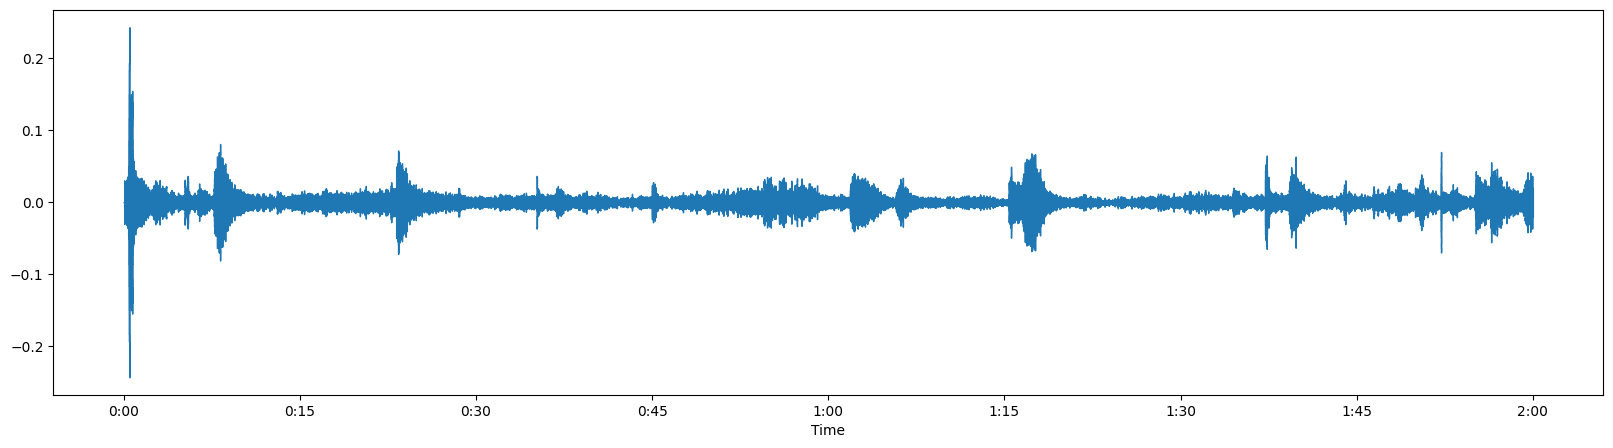

/content/drive/My Drive/video/HEIAN_NIDAN_camera_2_120s_ffmpeg.wav


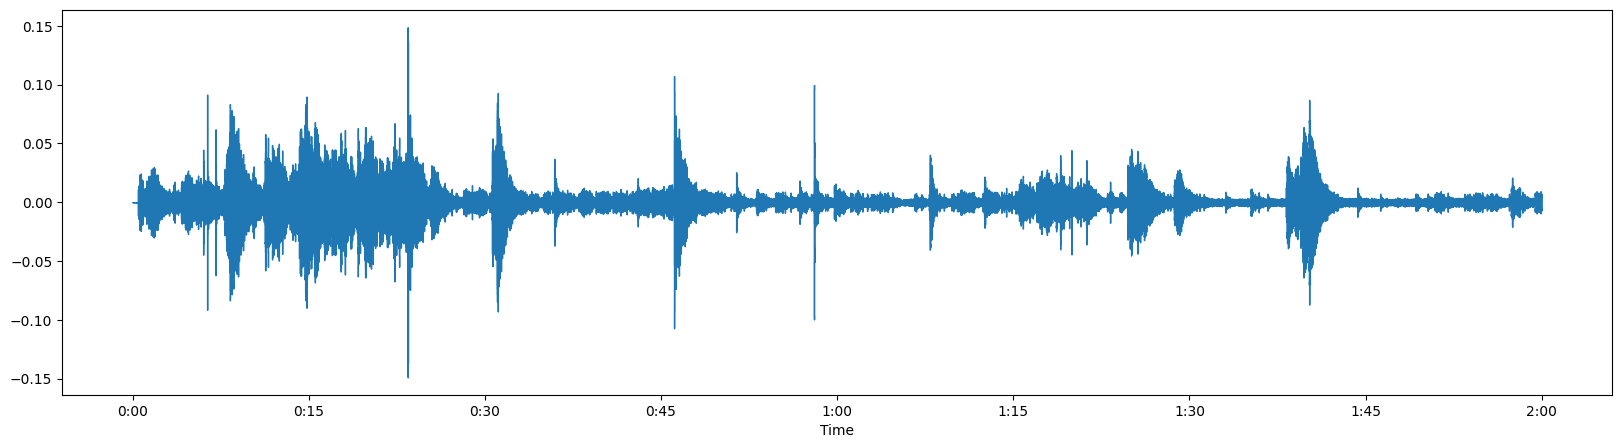

/content/drive/My Drive/video/HEIAN_NIDAN_camera_3_120s_ffmpeg.wav


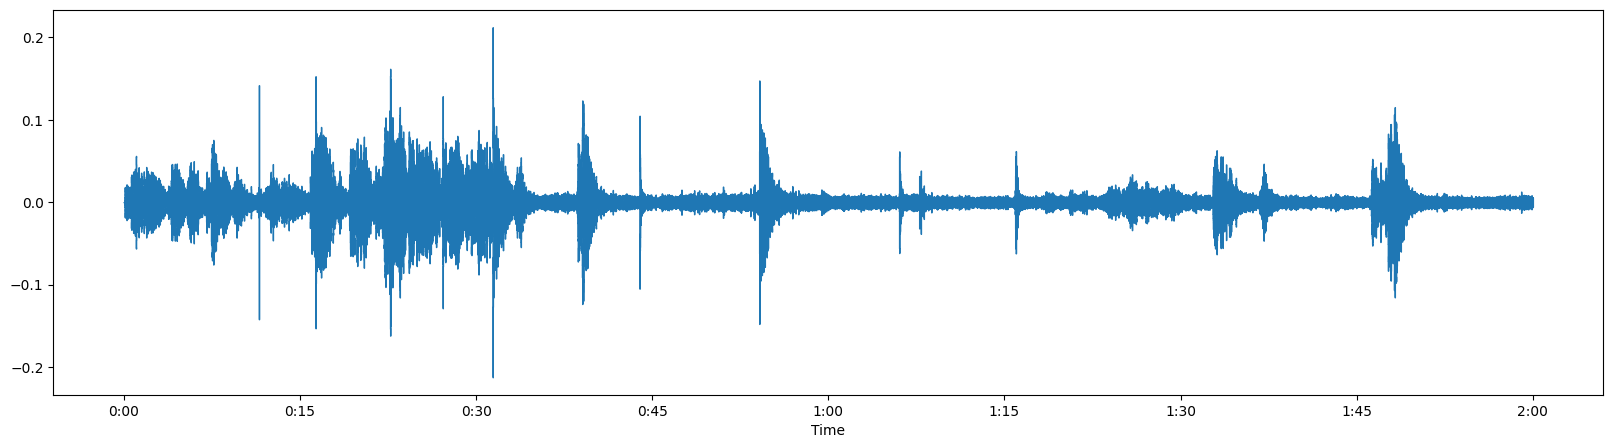

/content/drive/My Drive/video/HEIAN_NIDAN_camera_4_120s_ffmpeg.wav


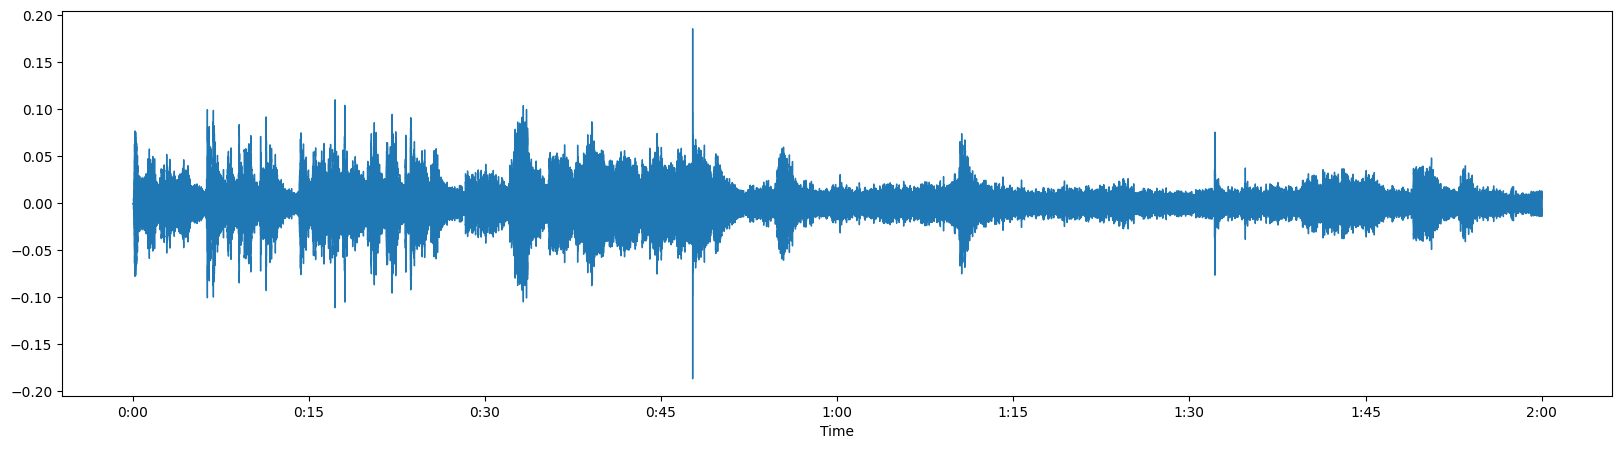

In [ ]:
for audio in audio_list:
    # Чтение аудиофайлов
    y1, sr1 = librosa.load(audio, sr=None)
    print (audio)
    # выведем временной ряд сигнала
    plt.figure(figsize=(20, 5))
    librosa.display.waveshow(y1, sr=sr1)
    plt.show()

In [ ]:
#@title Функция определяющая сдвиг аудио

from tqdm import tqdm  # Импортируем tqdm

def audio_cor (audio_1_path, audio_2_path):
    audio_1, sr_1 = librosa.load(audio_1_path, sr=None)
    audio_2, sr_2 = librosa.load(audio_2_path, sr=None)

    # Приведение массивов к одной длине
    min_length = min(len(audio_1), len(audio_2))
    audio_1 = audio_1[:min_length]
    audio_2 = audio_2[:min_length]

    # Параметры для сдвига
    shift_step = int(sr_1 / 30)  # Сдвиг на 1/30 секунды в выборках
    max_shift_samples = min_length  # Максимальный сдвиг в выборках
    correlation_coefficients = []

    # Вычисление коэффициента корреляции для каждого сдвига с tqdm
    for shift in tqdm(range(0, max_shift_samples + 1, shift_step), desc="Вычисление корреляции"):
        # Сдвиг audio_1 назад
        shifted_audio_1 = np.zeros_like(audio_1)

        if shift > 0:  # Если сдвиг больше 0
            shifted_audio_1[shift:] = audio_1[:-shift]
        else:  # Если сдвиг равен 0, просто копируем audio_1
            shifted_audio_1 = audio_1.copy()

        # Обрезка до пересечения
        min_length_shifted = min(len(shifted_audio_1), len(audio_2))
        shifted_audio_1 = shifted_audio_1[:min_length_shifted]
        audio_2_trimmed = audio_2[:min_length_shifted]

        # Вычисление коэффициента корреляции
        correlation = np.corrcoef(shifted_audio_1, audio_2_trimmed)[0, 1]
        correlation_coefficients.append(correlation)

    # Построение графика
    plt.figure(figsize=(20, 6))
    # Преобразуем индексы сдвига в секунды для оси X
    x_ticks = np.arange(0, max_shift_samples + 1, shift_step) / sr_1
    plt.plot(x_ticks, correlation_coefficients)
    plt.title('Коэффициент корреляции в зависимости от сдвига')
    plt.xlabel('Сдвиг (секунды)')
    plt.ylabel('Коэффициент корреляции')
    plt.grid()
    plt.xticks(np.arange(0, max_shift_samples / sr_1 + 0.1, 5))  # Установка меток по оси X
    plt.show()

    # Убираем NaN значения
    correlation_coefficients_np = np.array(correlation_coefficients)
    valid_indices = np.where(~np.isnan(correlation_coefficients_np))[0]
    valid_correlations = correlation_coefficients_np[valid_indices]

    # Находим 3 максимальных значения среди ненулевых
    top_indices = valid_indices[np.argsort(valid_correlations)[-3:]]  # Индексы трех максимальных значений
    top_correlations = valid_correlations[np.argsort(valid_correlations)[-3:]]  # Три максимальных значения корреляции
    top_shifts = top_indices * shift_step  # Соответствующие сдвиги в выборках

    # Преобразование сдвигов в секунды
    top_shifts_seconds = top_shifts / sr_1

    # Вывод результатов
    for i in range(len(top_correlations)):
        print(f'Сдвиг {audio_1_path} относительно {audio_2_path}')
        print(f"Максимальная корреляция: {top_correlations[i]:.4f}, Время сдвига: {top_shifts_seconds[i]:.4f} секунд")

Вычисление корреляции: 100%|██████████| 3601/3601 [06:45<00:00,  8.87it/s]


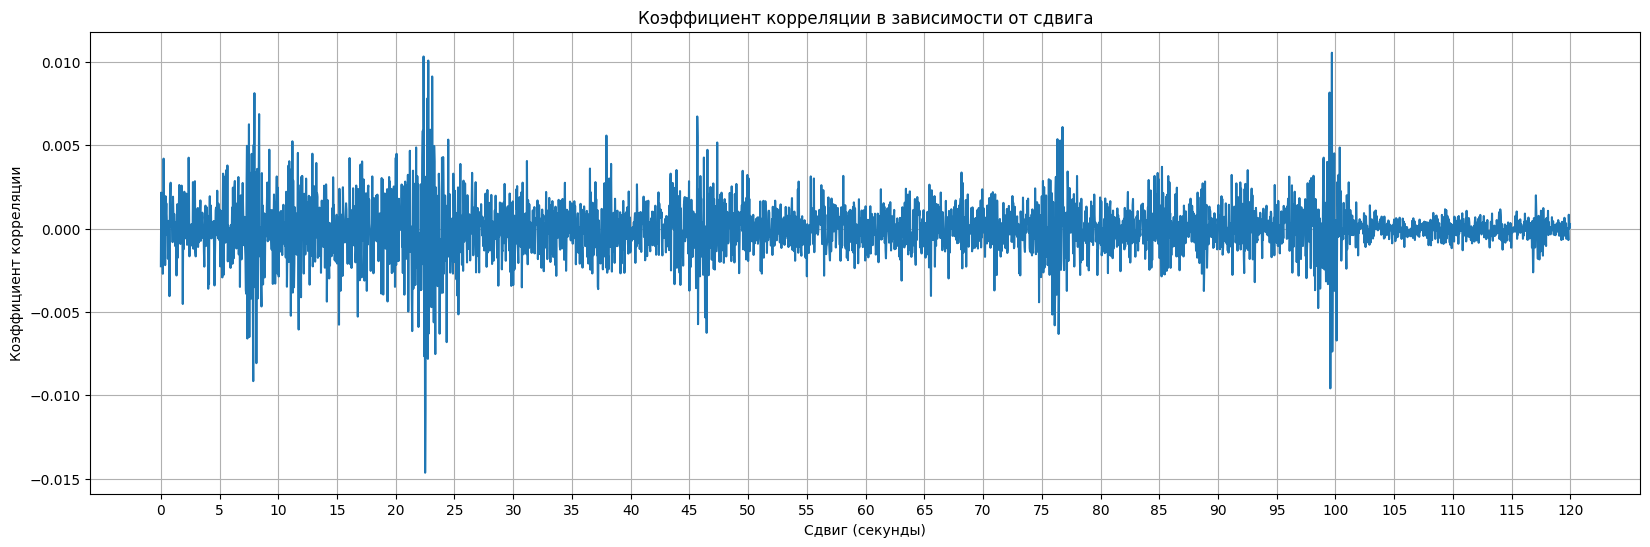

Сдвиг /content/drive/My Drive/video/HEIAN_NIDAN_camera_1_120s_ffmpeg.wav относительно /content/drive/My Drive/video/HEIAN_NIDAN_camera_2_120s_ffmpeg.wav
Максимальная корреляция: 0.0101, Время сдвига: 22.7667 секунд
Сдвиг /content/drive/My Drive/video/HEIAN_NIDAN_camera_1_120s_ffmpeg.wav относительно /content/drive/My Drive/video/HEIAN_NIDAN_camera_2_120s_ffmpeg.wav
Максимальная корреляция: 0.0103, Время сдвига: 22.3667 секунд
Сдвиг /content/drive/My Drive/video/HEIAN_NIDAN_camera_1_120s_ffmpeg.wav относительно /content/drive/My Drive/video/HEIAN_NIDAN_camera_2_120s_ffmpeg.wav
Максимальная корреляция: 0.0106, Время сдвига: 99.7000 секунд


Вычисление корреляции: 100%|██████████| 3601/3601 [06:41<00:00,  8.96it/s]


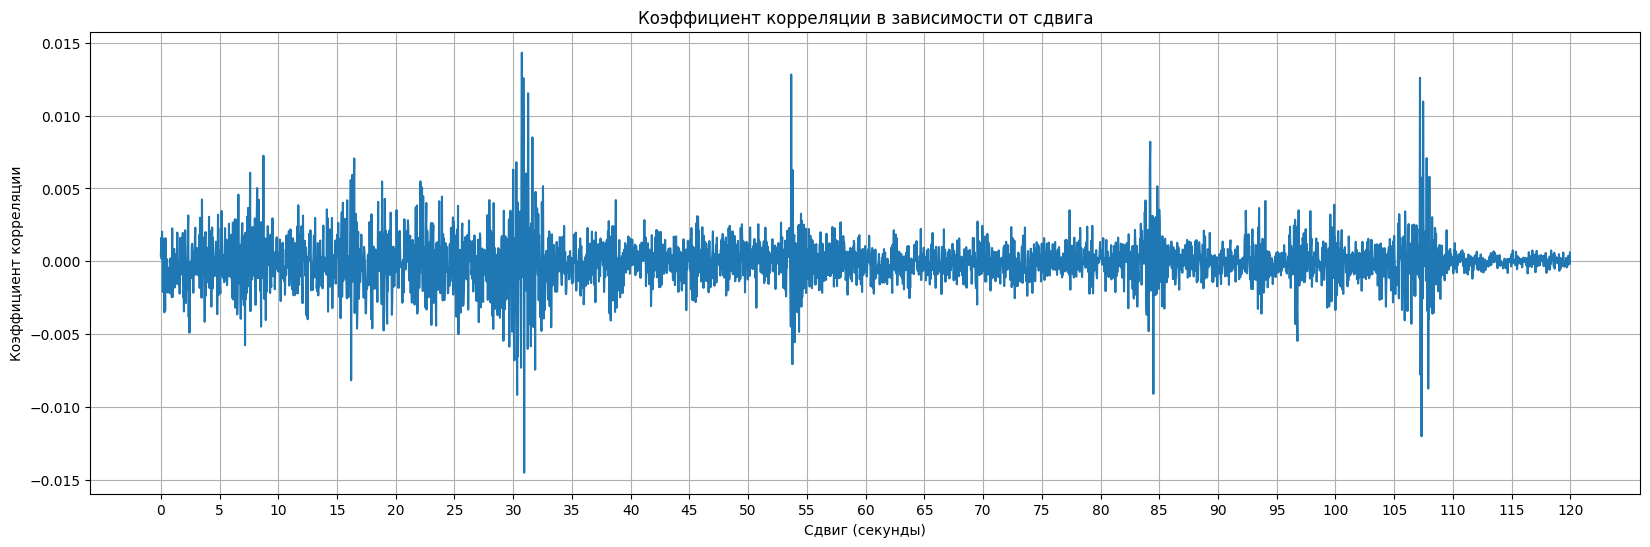

Сдвиг /content/drive/My Drive/video/HEIAN_NIDAN_camera_1_120s_ffmpeg.wav относительно /content/drive/My Drive/video/HEIAN_NIDAN_camera_3_120s_ffmpeg.wav
Максимальная корреляция: 0.0126, Время сдвига: 107.2000 секунд
Сдвиг /content/drive/My Drive/video/HEIAN_NIDAN_camera_1_120s_ffmpeg.wav относительно /content/drive/My Drive/video/HEIAN_NIDAN_camera_3_120s_ffmpeg.wav
Максимальная корреляция: 0.0128, Время сдвига: 53.6667 секунд
Сдвиг /content/drive/My Drive/video/HEIAN_NIDAN_camera_1_120s_ffmpeg.wav относительно /content/drive/My Drive/video/HEIAN_NIDAN_camera_3_120s_ffmpeg.wav
Максимальная корреляция: 0.0143, Время сдвига: 30.7333 секунд


Вычисление корреляции: 100%|██████████| 3601/3601 [06:48<00:00,  8.82it/s]


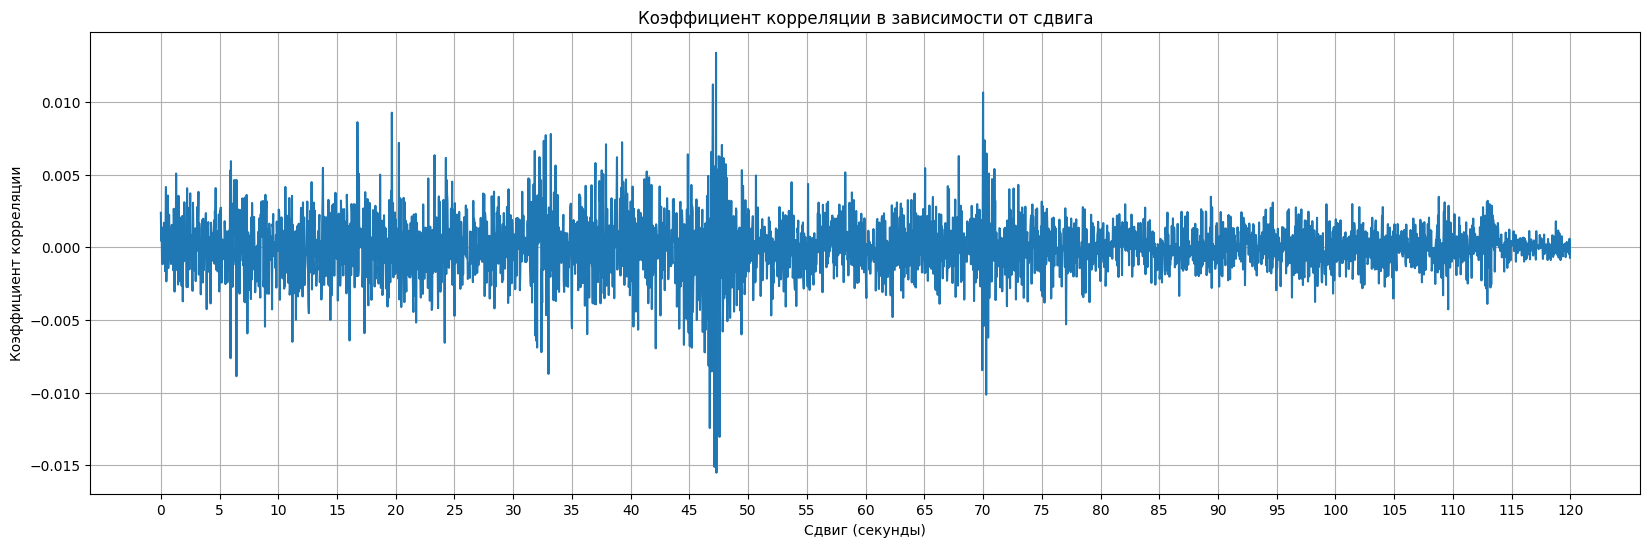

Сдвиг /content/drive/My Drive/video/HEIAN_NIDAN_camera_1_120s_ffmpeg.wav относительно /content/drive/My Drive/video/HEIAN_NIDAN_camera_4_120s_ffmpeg.wav
Максимальная корреляция: 0.0106, Время сдвига: 70.0000 секунд
Сдвиг /content/drive/My Drive/video/HEIAN_NIDAN_camera_1_120s_ffmpeg.wav относительно /content/drive/My Drive/video/HEIAN_NIDAN_camera_4_120s_ffmpeg.wav
Максимальная корреляция: 0.0112, Время сдвига: 47.0000 секунд
Сдвиг /content/drive/My Drive/video/HEIAN_NIDAN_camera_1_120s_ffmpeg.wav относительно /content/drive/My Drive/video/HEIAN_NIDAN_camera_4_120s_ffmpeg.wav
Максимальная корреляция: 0.0134, Время сдвига: 47.2667 секунд


Вычисление корреляции: 100%|██████████| 3601/3601 [06:50<00:00,  8.78it/s]


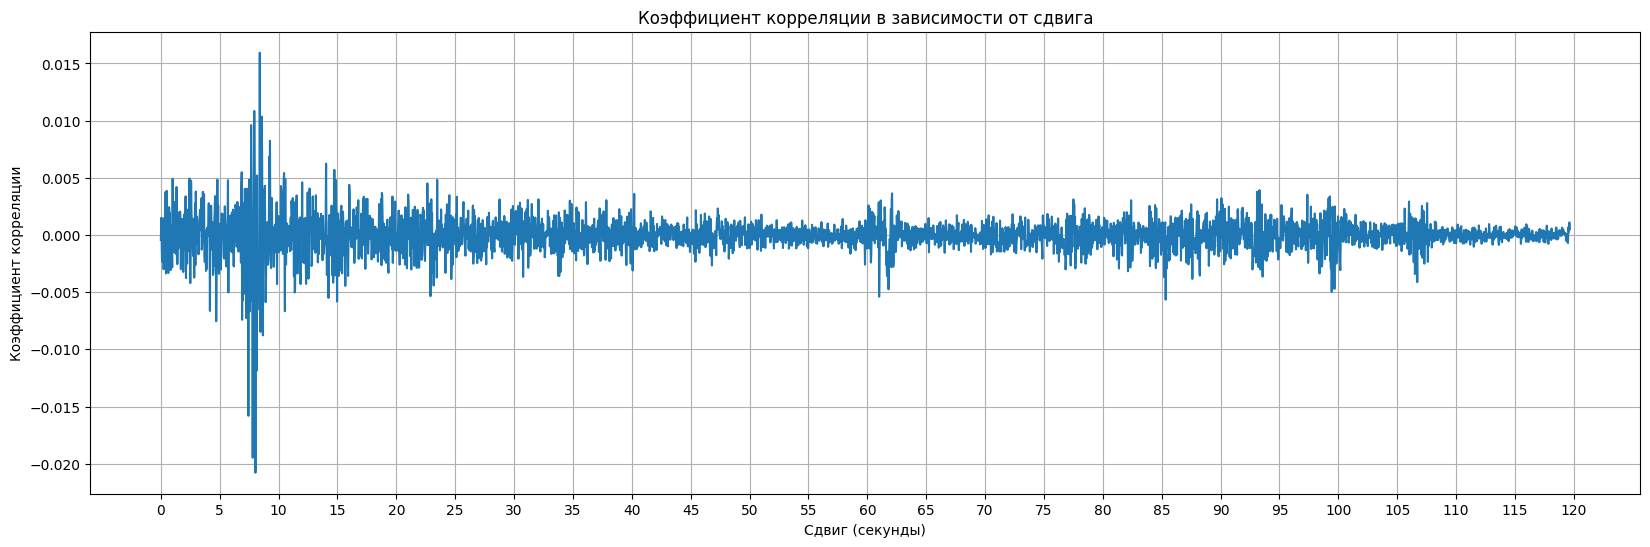

Сдвиг /content/drive/My Drive/video/HEIAN_NIDAN_camera_2_120s_ffmpeg.wav относительно /content/drive/My Drive/video/HEIAN_NIDAN_camera_3_120s_ffmpeg.wav
Максимальная корреляция: 0.0103, Время сдвига: 8.5667 секунд
Сдвиг /content/drive/My Drive/video/HEIAN_NIDAN_camera_2_120s_ffmpeg.wav относительно /content/drive/My Drive/video/HEIAN_NIDAN_camera_3_120s_ffmpeg.wav
Максимальная корреляция: 0.0108, Время сдвига: 7.9333 секунд
Сдвиг /content/drive/My Drive/video/HEIAN_NIDAN_camera_2_120s_ffmpeg.wav относительно /content/drive/My Drive/video/HEIAN_NIDAN_camera_3_120s_ffmpeg.wav
Максимальная корреляция: 0.0159, Время сдвига: 8.4000 секунд


Вычисление корреляции: 100%|██████████| 3601/3601 [06:45<00:00,  8.88it/s]


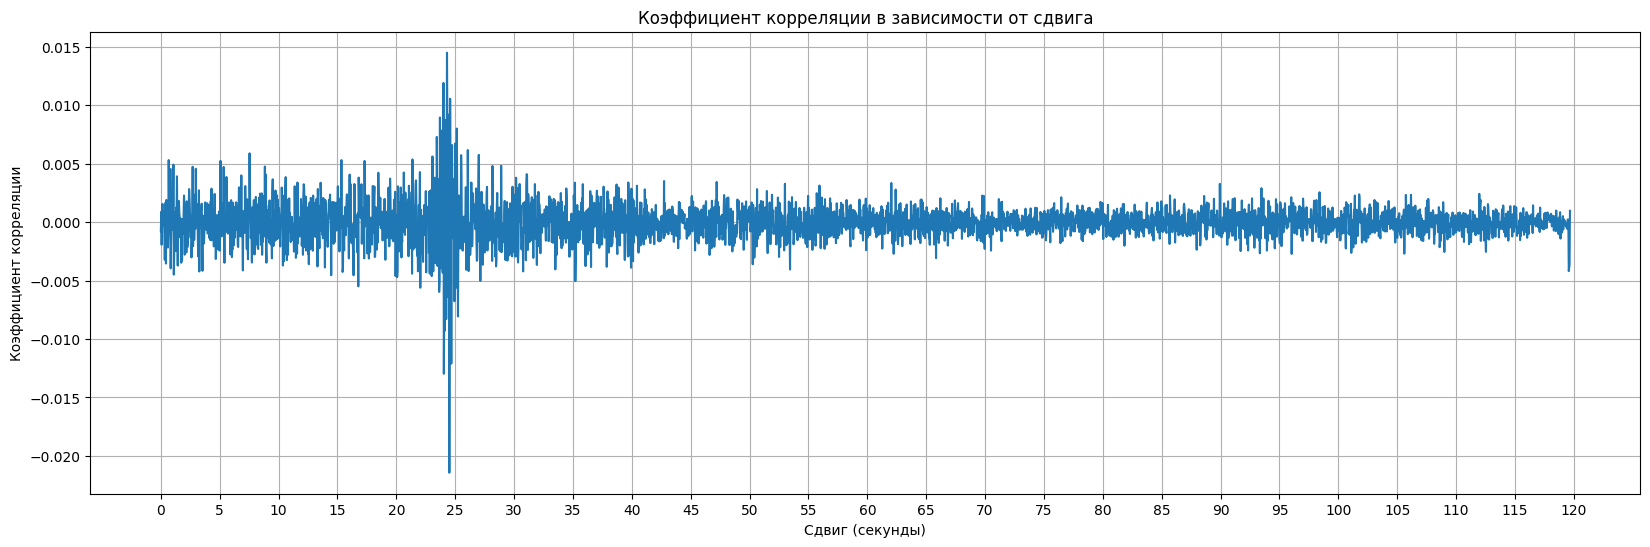

Сдвиг /content/drive/My Drive/video/HEIAN_NIDAN_camera_2_120s_ffmpeg.wav относительно /content/drive/My Drive/video/HEIAN_NIDAN_camera_4_120s_ffmpeg.wav
Максимальная корреляция: 0.0105, Время сдвига: 24.5667 секунд
Сдвиг /content/drive/My Drive/video/HEIAN_NIDAN_camera_2_120s_ffmpeg.wav относительно /content/drive/My Drive/video/HEIAN_NIDAN_camera_4_120s_ffmpeg.wav
Максимальная корреляция: 0.0119, Время сдвига: 24.0000 секунд
Сдвиг /content/drive/My Drive/video/HEIAN_NIDAN_camera_2_120s_ffmpeg.wav относительно /content/drive/My Drive/video/HEIAN_NIDAN_camera_4_120s_ffmpeg.wav
Максимальная корреляция: 0.0145, Время сдвига: 24.3000 секунд


Вычисление корреляции: 100%|██████████| 3601/3601 [06:45<00:00,  8.88it/s]


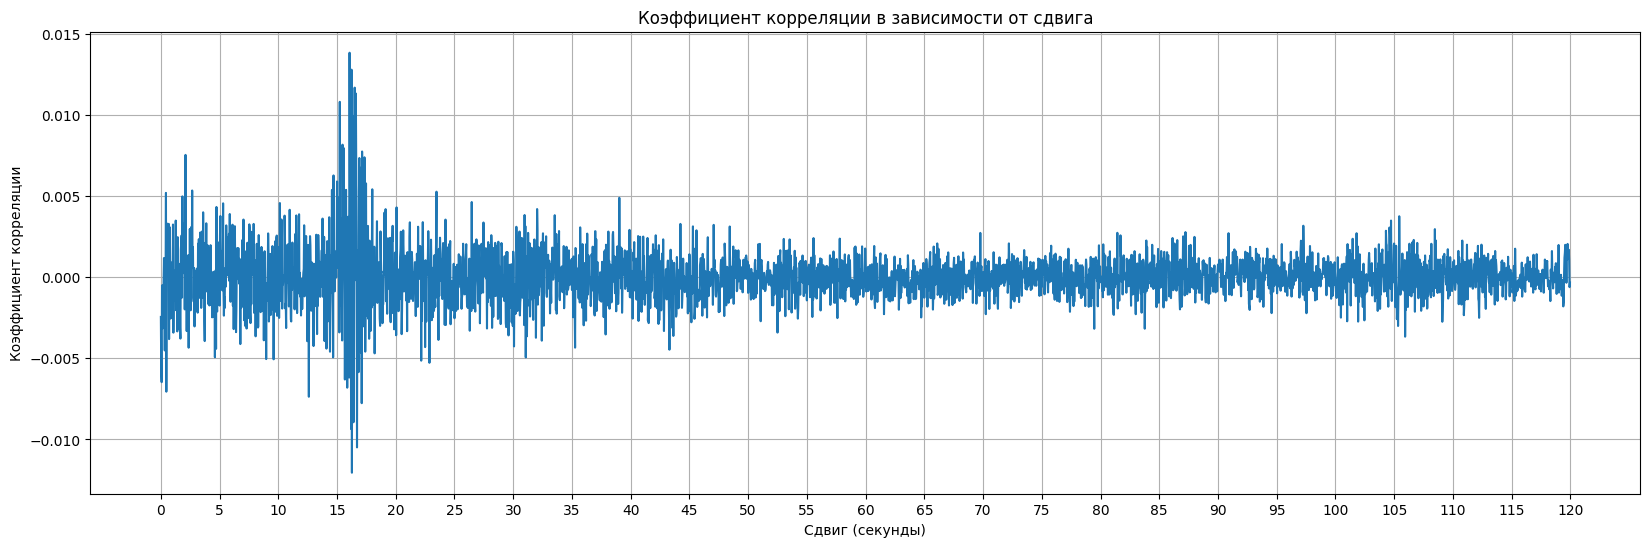

Сдвиг /content/drive/My Drive/video/HEIAN_NIDAN_camera_3_120s_ffmpeg.wav относительно /content/drive/My Drive/video/HEIAN_NIDAN_camera_4_120s_ffmpeg.wav
Максимальная корреляция: 0.0117, Время сдвига: 16.5000 секунд
Сдвиг /content/drive/My Drive/video/HEIAN_NIDAN_camera_3_120s_ffmpeg.wav относительно /content/drive/My Drive/video/HEIAN_NIDAN_camera_4_120s_ffmpeg.wav
Максимальная корреляция: 0.0128, Время сдвига: 16.2333 секунд
Сдвиг /content/drive/My Drive/video/HEIAN_NIDAN_camera_3_120s_ffmpeg.wav относительно /content/drive/My Drive/video/HEIAN_NIDAN_camera_4_120s_ffmpeg.wav
Максимальная корреляция: 0.0139, Время сдвига: 16.0667 секунд


In [ ]:
for i in range(len(audio_list)):
    for j in range(i + 1, len(audio_list)):
        audio_cor(audio_list[i], audio_list[j])

In [ ]:
#@title Определяем правильную величину сдвига
shifts = {
    ('cam_1', 'cam_2'): [22.7667, 22.3667, 99.7000],
    ('cam_1', 'cam_3'): [107.2000, 53.6667, 30.7333],
    ('cam_1', 'cam_4'): [70.0000, 47.0000, 47.2667],
    ('cam_2', 'cam_3'): [8.5667, 7.9333, 8.4000],
    ('cam_2', 'cam_4'): [24.5667, 24.0000, 24.3000],
    ('cam_3', 'cam_4'): [16.5000, 16.2333, 16.0667],
}

# Определяем камеру, с которой будем сравнивать
camera_of_interest = 'cam_1'

# Ищем сдвиги между cam_1 и другими камерами
for (cam1, cam2), values in shifts.items():
    if cam1 == camera_of_interest:
        if cam2 == 'cam_3':
            shift = values[2]  # Получаем третий элемент для cam_3
        elif cam2 == 'cam_4':
            shift = values[2]  # Получаем третий элемент для cam_4
        else:
            shift = values[0]  # Получаем первый элемент для остальных
        print(f"Сдвиг между {cam1} и {cam2}: {shift} секунд")

Сдвиг между cam_1 и cam_2: 22.7667 секунд
Сдвиг между cam_1 и cam_3: 30.7333 секунд
Сдвиг между cam_1 и cam_4: 47.2667 секунд
